In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import zipfile
import tarfile
import h5py
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
from itertools import zip_longest
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize

## Functions

In [2]:
def load_images_from_dirs(directories):
    images = []
    for directory in directories:
        image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
        for file_name in image_files:
            file_path = os.path.join(directory, file_name)  # Create the full file path
            img = Image.open(file_path)  # Open the image file
            img = np.array(img)  # Convert PIL image to numpy array
            images.append(img)  # Add the image to the list

    return images

# Example usage:
#train_dirs = ['path/to/trainDir', 'path/to/trainDir/captured']  # Example directories


In [3]:
class PixelLabelDatastore:
    def __init__(self, directories, class_names, pixel_label_ids):
        self.class_names = class_names
        self.pixel_label_ids = pixel_label_ids
        self.pixel_labels = self.load_pixel_labels_from_dirs(directories)

    def load_pixel_labels_from_dirs(self, directories):
        pixel_labels = []
        for directory in directories:
            if not os.path.exists(directory):
                print(f"Directory does not exist: {directory}")
                continue
            
            hfive_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
            for file_name in hfive_files:
                file_path = os.path.join(directory, file_name)
                if not os.path.exists(file_path):
                    print(f"File does not exist: {file_path}")
                    continue
                    
                try:
                    with h5py.File(file_path, 'r') as hfive_file:
                        if 'labels' in hfive_file:
                            label_data = hfive_file['labels'][:]
                            original_labels_copy = np.copy(label_data)
                            mapped_labels = self.map_pixel_values_to_classes(original_labels_copy)
                            pixel_labels.append({
                                'original': original_labels_copy,
                                'mapped': mapped_labels
                            })
                        else:
                            print(f"'labels' dataset not found in {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

        return pixel_labels

    def map_pixel_values_to_classes(self, label_data):
        value_to_class = dict(zip(self.pixel_label_ids, self.class_names))
        return np.vectorize(value_to_class.get)(label_data)

    def get_original_labels(self):
        # Collect and return all original labels
        return [sample['original'] for sample in self.pixel_labels]


In [4]:
class PixelLabelDatastore:
    def __init__(self, directories, class_names):
        self.class_names = class_names
        self.pixel_label_ids = np.arange(len(class_names))  # Sequential IDs: 0, 1, 2, ...
        self.pixel_labels = self.load_pixel_labels_from_dirs(directories)

    def load_pixel_labels_from_dirs(self, directories):
        pixel_labels = []
        for directory in directories:
            if not os.path.exists(directory):
                print(f"Directory does not exist: {directory}")
                continue

            hfive_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
            for file_name in hfive_files:
                file_path = os.path.join(directory, file_name)
                if not os.path.exists(file_path):
                    print(f"File does not exist: {file_path}")
                    continue

                try:
                    with h5py.File(file_path, 'r') as hfive_file:
                        if 'labels' in hfive_file:
                            label_data = hfive_file['labels'][:]
                            # Map pixel values to numeric indices
                            numeric_labels = self.map_pixel_values_to_indices(label_data)
                            # Map numeric indices to class names
                            class_name_labels = self.map_indices_to_class_names(numeric_labels)
                            pixel_labels.append({
                                'original': numeric_labels,      # Numeric indices (0, 1, 2, ...)
                                'mapped': class_name_labels      # Class names ("Noise", "NR", ...)
                            })
                        else:
                            print(f"'labels' dataset not found in {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

        return pixel_labels

    def map_pixel_values_to_indices(self, label_data):
        # Map raw pixel values to sequential class indices (0, 1, 2, ...)
        raw_to_sequential = {raw: idx for idx, raw in enumerate(
            np.floor(np.arange(len(self.class_names)) / (len(self.class_names) - 1) * 255).astype(int)
        )}
        # Assign the "Unknown" class index (e.g., 3) to any value not in raw_to_sequential
        return np.vectorize(lambda x: raw_to_sequential.get(x, len(self.class_names) - 1))(label_data)

    def map_indices_to_class_names(self, numeric_labels):
        # Map numeric indices (0, 1, 2, ...) to class names
        return np.vectorize(lambda idx: self.class_names[idx])(numeric_labels)

    def get_original_labels(self):
        # Collect and return all original numeric labels
        return [sample['original'] for sample in self.pixel_labels]

    def get_mapped_labels(self):
        # Collect and return all mapped class name labels
        return [sample['mapped'] for sample in self.pixel_labels]

In [5]:
import numpy as np

def helper_spec_sense_partition_data(imds, pxds, parts):
    """
    Partitions the image and pixel label datasets into training, validation, and test subsets.

    Parameters:
        imds (list): List of images (numpy arrays).
        pxds (list): List of pixel label datasets (numpy arrays).
        parts (list): A 1x3 list of percentages [train, validation, test].
                     The sum of the elements must equal 100.

    Returns:
        tuple:
        - imds_train, pxds_train: Training data subsets.
        - imds_val, pxds_val: Validation data subsets.
        - imds_test, pxds_test: Test data subsets.
    """
    # Validate input
    if len(parts) != 2 or sum(parts) != 100:
        raise ValueError("Parts must be a list of three elements summing to 100.")

    # Set random seed for reproducibility
    np.random.seed(0)

    # Shuffle indices
    num_files = len(imds)
    shuffled_indices = np.random.permutation(num_files)

    # Compute split indices
    num_train = int(num_files * parts[0] / 100)
    

    # Split data
    train_indices = shuffled_indices[:num_train]
    test_indices = shuffled_indices[num_train:]

    # Subset data
    imds_train = [imds[i] for i in train_indices]
    pxds_train = [pxds[i] for i in train_indices]

    imds_test = [imds[i] for i in test_indices]
    pxds_test = [pxds[i] for i in test_indices]

    # Stack all original labels and images into single NumPy arrays for efficient tensor creation
    labels_train = np.stack([sample['original'] for sample in pxds_train], axis=0)
    images_train = np.stack(imds_train, axis=0)

    labels_test = np.stack([sample['original'] for sample in pxds_test], axis=0)
    images_test = np.stack(imds_test, axis=0)

    # Return both partitioned and stacked datasets
    return images_train, labels_train, images_test, labels_test


In [6]:
# Combine datasets for final use
def combine(imds, pxds):
    """Combine image and pixel label datasets."""
    return list(zip_longest(imds, pxds))

In [7]:
from torch.utils.data import Dataset

class ImageLabelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [8]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score

def evaluate_model(model, val_loader, criterion, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, labels in tqdm(val_loader, desc='Validation', unit='batch'):
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect predictions and true labels for metric calculation
            preds = torch.argmax(outputs, dim=1)  # Get class predictions (shape: [batch_size, height, width])
            all_preds.append(preds.cpu().numpy())  # Store the predictions (move to CPU)
            all_labels.append(labels.cpu().numpy())  # Store the true labels (move to CPU)

    # Flatten all predictions and labels to calculate metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()  # Flatten predictions
    all_labels = np.concatenate(all_labels, axis=0).flatten()  # Flatten true labels

    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()  # Pixel-level accuracy
    f1 = f1_score(all_labels, all_preds, average='weighted')  # F1 score (weighted)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    iou = jaccard_score(all_labels, all_preds, average='weighted')  # IoU using sklearn's jaccard_score

    # Compute average loss
    avg_loss = running_loss / len(val_loader)

    print(f"Validation Loss: {avg_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

    return avg_loss, accuracy, f1, precision, recall, iou


## Training Data directory and class setup

In [9]:
train_data_dir =[r'C:\Users\mathu\OneDrive\Desktop\EEE Y4.S1\FYP\MATLAB data generation finalised\TrainingData\128x128\LTE_NR']
class_names = ["Noise", "NR", "LTE", "Unknown"]  # Define class names
num_classes = len(class_names)
pixel_label_ids = np.floor(np.arange(num_classes) / (num_classes - 1) * 255).astype(int)

## Image datastore
A function that loads all .png images in each specified directory.
For each image, it:
- Collects file names ending in .png.
- Opens the image, converts it to a NumPy array, and appends it to images.
- This function will return a list of images (in NumPy array form) stored in training_images.


In [10]:
training_images = load_images_from_dirs(train_data_dir)
print(f"Loaded {len(training_images)} images.")

Loaded 918 images.


## Pixel Label Datastore, loading pixels and mapping pixel value to classes

 Loads pixel label data from .h5 files, where each file is expected to contain a dataset named 'labels'.
For each .h5 file:
- It checks if the file contains a labels dataset.
- If labels are found, it reads them as a NumPy array and maps the pixel values to class names using map_pixel_values_to_classes.

The pixel_labels list stores the final mapped labels.

This function uses pixel_label_ids and class_names to create a dictionary mapping pixel values to class names.
It then maps each pixel value in label_data to a corresponding class, allowing the model to understand the label format.

In [11]:
# Load pixel labels using the updated PixelLabelDatastore class
pxds_truth_lte_nr = PixelLabelDatastore(train_data_dir, class_names)

# Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Loaded {len(pxds_truth_lte_nr.pixel_labels)} sets of pixel labels.")




Loaded 918 sets of pixel labels.


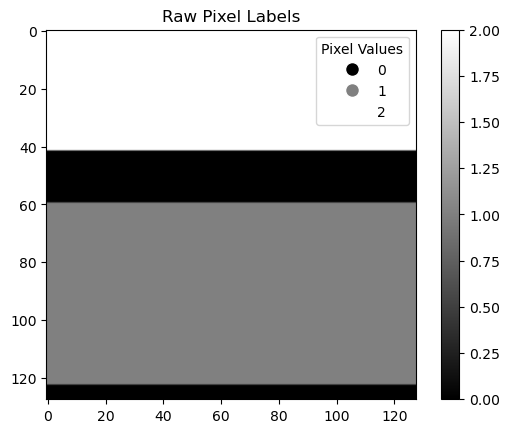

In [12]:
# Example: Accessing first sample and original labels from pxds_truth_lte_nr
first_sample = pxds_truth_lte_nr.pixel_labels[0]  # Get the first sample of labels
original_labels = first_sample['original']  # Assuming 'original' is the key where original labels are stored

# Display the raw label data
plt.imshow(original_labels, cmap='gray')  # Display the raw pixel labels
plt.title('Raw Pixel Labels')
plt.colorbar()

# Create a legend for the pixel values based on numerical values
unique_values = np.unique(original_labels)  # Get unique pixel values

# Create custom handles for the legend based on unique pixel values
handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(value),
                       markerfacecolor=plt.cm.gray(value / np.max(unique_values)), 
                       markersize=10) 
           for value in unique_values]

plt.legend(handles=handles, title="Pixel Values")
plt.show()


In [13]:
first_sample = pxds_truth_lte_nr.pixel_labels[0]  # Get the first sample of labels
original_labels = first_sample['mapped']
original_labels

array([['LTE', 'LTE', 'LTE', ..., 'LTE', 'LTE', 'LTE'],
       ['LTE', 'LTE', 'LTE', ..., 'LTE', 'LTE', 'LTE'],
       ['LTE', 'LTE', 'LTE', ..., 'LTE', 'LTE', 'LTE'],
       ...,
       ['Noise', 'Noise', 'Noise', ..., 'Noise', 'Noise', 'Noise'],
       ['Noise', 'Noise', 'Noise', ..., 'Noise', 'Noise', 'Noise'],
       ['Noise', 'Noise', 'Noise', ..., 'Noise', 'Noise', 'Noise']],
      dtype='<U5')

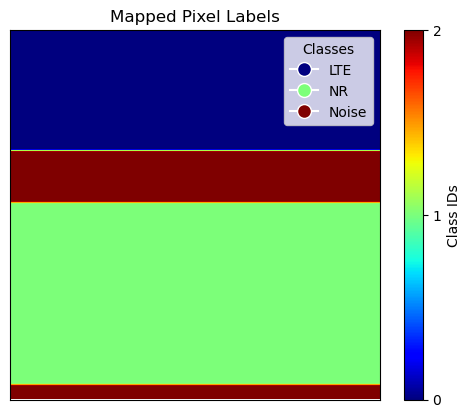

In [14]:
first_sample = pxds_truth_lte_nr.pixel_labels[0]  # Get the first sample of labels
first_mapped_labels = first_sample['mapped']

# Identify unique classes/values in the mapped labels
unique_classes = np.unique(first_mapped_labels)

# Create a mapping from class names to numerical IDs
class_mapping = {class_name: i for i, class_name in enumerate(unique_classes)}

# Create a numerical representation of the labels using the mapping
numerical_labels = np.vectorize(class_mapping.get)(first_mapped_labels)

# Display the mapped labels as an image
plt.imshow(numerical_labels, cmap='jet')  # Use an appropriate colormap
plt.title('Mapped Pixel Labels')
plt.colorbar(ticks=np.arange(len(unique_classes)), label='Class IDs')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

# Create custom handles for the legend based on unique pixel values
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w',
        label=class_name,
        markerfacecolor=plt.cm.jet(class_mapping[class_name] / (len(unique_classes)-1)),
        markersize=10
    )
    for class_name in unique_classes
]

# Add legend to the plot
plt.legend(handles=handles, title='Classes')

plt.show()




#### Optionally, print the first set of pixel labels (mapped to class names)
if pxds_truth_lte_nr.pixel_labels:
    print("First set of mapped pixel labels:\n", pxds_truth_lte_nr.pixel_labels[0])
     # Set print options to display the entire array
    np.set_printoptions(threshold=np.inf)  # Set threshold to infinity to show all elements

    # Print the entire mapped labels array
    print(first_mapped_labels)

    # Optionally reset print options to default after displaying
    np.set_printoptions(threshold=1000)  # Resetting to a reasonable threshold
else:
    print("No pixel labels found.")

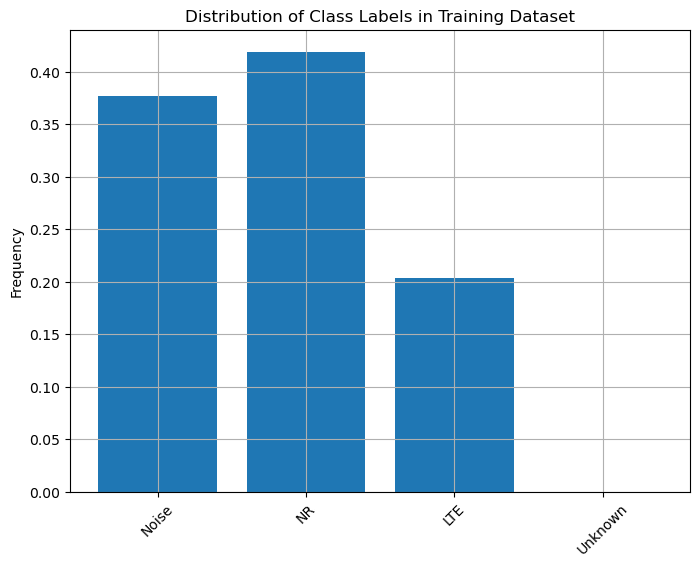

In [15]:
# Flatten all pixel labels across all images into a single array for counting
all_labels = np.concatenate([sample['original'].ravel() for sample in pxds_truth_lte_nr.pixel_labels])

# Count the occurrences of each class in all_labels
unique, counts = np.unique(all_labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# Calculate the frequency for each class based on total pixel count
total_pixels = sum(counts)
frequency = [label_counts.get(idx, 0) / total_pixels for idx in range(len(pxds_truth_lte_nr.class_names))]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(range(len(pxds_truth_lte_nr.class_names)), frequency)
plt.grid(True)
plt.xticks(range(len(pxds_truth_lte_nr.class_names)), pxds_truth_lte_nr.class_names, rotation=45)
plt.ylabel("Frequency")
plt.title("Distribution of Class Labels in Training Dataset")
plt.show()


## Train test datasplit

In [16]:
# Partition data
parts = [80, 20]  # 80% train, 10% validation, 10% test
imds_train, pxds_train, imds_test, pxds_test = helper_spec_sense_partition_data(
    training_images, pxds_truth_lte_nr.pixel_labels, parts)

In [17]:
cds_train = combine(imds_train, pxds_train)
cds_test = combine(imds_test, pxds_test)

print(f"Training set: {len(cds_train)} pairs")
print(f"Test set: {len(cds_test)} pairs")

Training set: 734 pairs
Test set: 184 pairs


## PyTorch tensors conversion

In [18]:
# Now you can convert the stacked arrays to tensors
images_train_tensor = torch.tensor(imds_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(pxds_train, dtype=torch.long)

images_test_tensor = torch.tensor(imds_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(pxds_test, dtype=torch.long)

# Normalize images (after converting to tensors)
images_train_tensor = images_train_tensor / 255.0
images_train_tensor = images_train_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

images_test_tensor = images_test_tensor / 255.0
images_test_tensor = images_test_tensor.permute(0, 3, 1, 2)

# Example of tensor shapes
print(f"Training images tensor shape: {images_train_tensor.shape}")
print(f"Training labels tensor shape: {labels_train_tensor.shape}")

print(f"Training images tensor shape: {images_test_tensor.shape}")
print(f"Training labels tensor shape: {labels_test_tensor.shape}")

Training images tensor shape: torch.Size([734, 3, 128, 128])
Training labels tensor shape: torch.Size([734, 128, 128])
Training images tensor shape: torch.Size([184, 3, 128, 128])
Training labels tensor shape: torch.Size([184, 128, 128])


# Check for invalid label values
invalid_labels = torch.any(labels < 0) or torch.any(labels >= num_classes)
if invalid_labels:
    print(f"Invalid labels found: {torch.unique(labels)}")
else:
    print(f"Labels seem valid.")

## Data Loading

In [19]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = ImageLabelDataset(images=images_train_tensor, labels=labels_train_tensor)
test_dataset = ImageLabelDataset(images=images_test_tensor, labels=labels_test_tensor)

# Create DataLoaders
batch_size = 16  # You can adjust the batch size based on your available memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for images, labels in train_loader:
    print(f"Images type: {type(images)}, Labels type: {type(labels)}")
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

## Building custom model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleSemanticSegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSemanticSegmentationNet, self).__init__()

        # Encoder (Feature extraction with standard convolutions)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling
        )

        # Multi-scale feature extraction (Alternative to ASPP)
        self.multi_scale = nn.ModuleList([
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # Smallest scale
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Medium scale
            nn.Conv2d(512, 512, kernel_size=5, padding=2)   # Largest scale
        ])

        # Decoder (Progressive upsampling with ConvTranspose2d)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, num_classes, kernel_size=(1, 1))  # Final classification layer
        )

    def forward(self, x):
        #print(f"Input shape: {x.shape}")  # Debugging input shape

        # Pass through the encoder
        x = self.encoder(x)
        #print(f"After encoder: {x.shape}")  # Debugging shape after encoder

        # Apply multi-scale convolutions and sum the outputs
        multi_scale_outputs = [conv(x) for conv in self.multi_scale]
        #for i, feat in enumerate(multi_scale_outputs):
            #print(f"Multi-scale feature {i} shape: {feat.shape}")

        multi_scale_features = torch.sum(torch.stack(multi_scale_outputs), dim=0)
        #print(f"After multi-scale fusion: {multi_scale_features.shape}")

        # Pass through the decoder
        x = self.decoder(multi_scale_features)
        #print(f"After decoder: {x.shape}")  # Debugging shape after decoder

        return x

# Define the network
num_classes = len(torch.unique(labels_train_tensor))  # Example number of classes
model = SimpleSemanticSegmentationNet(num_classes)

# Generate a dummy input tensor with shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 128, 128)  # Batch size = 1, 3 channels, 128x128 image

# Forward pass with debugging prints
output = model(dummy_input)

print(f"Output shape: {output.shape}")  # Final output shape

# Summary of the model
print(model)


Output shape: torch.Size([1, 3, 128, 128])
SimpleSemanticSegmentationNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### Model Description

Purpose:  Designed to classify each pixel of an image into one of the specified classes (Noise, NR, LTE, Unkown)

##### Encoder (Feature extraction):
- Purpose: Extract high-level features from the input image
- Operations:
    1. It consists of a series of convolutional layers (Conv2d) with ReLU activation functions and batch normalization (BatchNorm2d) to stabilize the training.
    2. After each convolutional layer, max-pooling (MaxPool2d) is applied to downsample the feature maps, reducing their spatial dimensions.
    3. The encoder captures spatial patterns and reduces the resolution of the input image step by step.
- The layers used are:
    1. Conv2d with increasing output channels: 64, 128, 256, 512.
    2. Max pooling at each stage to reduce the spatial resolution.
##### Multi-scale feature extraction (Alternative to ASPP):
- Purpose: Capture features at different scales to help the model recognize objects or patterns of varying sizes.
- Operations:
    1. Three convolutional layers (Conv2d) are applied with different kernel sizes: 1, 3, and 5. This allows the model to process the image at different receptive fields (scales).
    2. The outputs of these convolutions are summed together to combine multi-scale features, helping the network capture different spatial patterns effectively.
##### Decoder (Upsampling to original resolution):
- Purpose: Upsample the features to the original image resolution and prepare them for pixel-wise classification.
- Operations:
    1. It consists of a series of transposed convolution layers (ConvTranspose2d), each followed by ReLU and batch normalization.
    2. The transposed convolutions progressively upsample the feature maps, which increases the spatial dimensions back to the original size (i.e., from reduced resolution in the encoder).
    3. The final layer (Conv2d) produces the output with the number of channels equal to num_classes, which corresponds to the number of classes for semantic segmentation. This is the pixel-wise classification output.
##### Forward Pass:
1. The input image x passes through the encoder, which extracts high-level features.
2. Multi-scale convolutions are then applied on the encoder output, and the results are summed together.
3. The combined multi-scale features are passed through the decoder, which upsamples them and finally outputs a segmentation map of size (num_classes, height, width).
##### Example Usage:
Input: A dummy input tensor of shape (1, 3, 128, 128), where:
1 is the batch size.

3 is the number of input channels (RGB image).

128x128 is the height and width of the image.

Output: The output tensor will have a shape of (1, num_classes, 128, 128), where num_classes is the number of segmentation classes (4 in this case), and 128x128 is the output image size.

#### Common Terms:

##### Convolutional Layers (Conv2d):
Definition: Convolutional layers are the core building blocks of Convolutional Neural Networks (CNNs). They are used to automatically learn spatial hierarchies of features from input data (usually images).


Function: A convolutional layer applies a series of small filters (kernels) to the input image or feature map. These filters slide over the image, performing element-wise multiplication between the filter and the part of the image it is over, followed by summing the result. This produces a feature map.

##### ReLU Activation: 
After the convolution operation, an activation function like ReLU (Rectified Linear Unit) is applied. ReLU transforms negative values into zero and leaves positive values unchanged.

Why: This introduces non-linearity, helping the network learn complex patterns.
##### Batch Normalization (BatchNorm2d): 
This is a technique to normalize the activations of the neurons in each mini-batch. It adjusts and scales the output of the convolutional layer to reduce internal covariate shift.
Why: It speeds up training, makes the model more stable, and can lead to better performance.
#####  Max-Pooling (MaxPool2d):
Definition: Max-pooling is a downsampling operation used to reduce the spatial dimensions (height and width) of the input feature maps. It is typically applied after convolutional layers.

Function: Max-pooling selects the maximum value from a specific region (a window) of the feature map. For example, if the window size is 2x2, it will take the largest value from the 2x2 block and discard the rest.

Why: Max-pooling reduces the size of the feature maps, helping the network become more computationally efficient and invariant to small translations in the image (i.e., it becomes less sensitive to small shifts in the input).
##### Receptive Fields (Scales):
Definition: The receptive field refers to the region of the input image that a neuron in the network can "see" or "sense" as it processes the image.


Function: When a convolutional layer applies a filter, each neuron in the output feature map is looking at a small portion of the input image. This small portion is the receptive field.

eg:
- Small scale (1x1 filter): Looks at fine, detailed patterns.
- Medium scale (3x3 filter): Captures slightly broader patterns.
- Large scale (5x5 filter): Captures large patterns or structures.

Why: Using multiple receptive fields (scales) helps the network capture information at different levels of abstraction—small details, medium patterns, and large structures.

##### ConvTranspose2d (Deconvolution or Upsampling):
Definition: ConvTranspose2d is the reverse operation of a convolution. Instead of reducing the spatial dimensions like convolution does, it increases the spatial dimensions of the input feature map (also called upsampling or deconvolution).

Function: It applies a filter to the input but performs an operation that effectively "upsamples" the feature map. This is commonly used in decoder sections of segmentation networks to restore the spatial resolution after downsampling in the encoder.

Why: The purpose is to reconstruct the high-resolution output (like a segmentation mask) from the downsampled features extracted in the encoder part of the network.

### Define loss function and optimiser

In [21]:
# Set device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleSemanticSegmentationNet(num_classes).to(device)


# CrossEntropyLoss for segmentation tasks
criterion = nn.CrossEntropyLoss()

# Adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

num_epochs = 10  # Set the number of epochs for training

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_baseline = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels
    
    # Wrap the train_loader with tqdm for a progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tepoch:
        for images, labels in tepoch:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Collect predictions and true labels for metric calculation
            preds = torch.argmax(outputs, dim=1)  # Get class predictions (shape: [batch_size, height, width])
            
            all_preds.append(preds.cpu().numpy())  # Store the predictions (move to CPU)
            all_labels.append(labels.cpu().numpy())  # Store the true labels (move to CPU)

            # Update progress bar with loss info
            tepoch.set_postfix(loss=loss.item())

    # Flatten all predictions and labels to calculate metrics
    all_preds = np.concatenate(all_preds, axis=0)  # Concatenate predictions
    all_labels = np.concatenate(all_labels, axis=0)  # Concatenate true labels

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()  # Pixel-level accuracy
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')  # F1 score (weighted)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)

    # Store accuracy for this epoch
    accuracy_per_epoch_baseline.append(accuracy)

    # Print statistics every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_baseline}")


Epoch 1/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:09<00:00,  5.00batch/s, loss=1.06]


Epoch [1/10], Loss: 1.0891, Accuracy: 0.4032, F1 Score: 0.3826, Precision: 0.3792, Recall: 0.4032


Epoch 2/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:08<00:00,  5.27batch/s, loss=1.07]


Epoch [2/10], Loss: 1.0494, Accuracy: 0.4411, F1 Score: 0.3798, Precision: 0.4002, Recall: 0.4411


Epoch 3/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.87batch/s, loss=1.03]


Epoch [3/10], Loss: 1.0321, Accuracy: 0.4682, F1 Score: 0.4020, Precision: 0.4113, Recall: 0.4682


Epoch 4/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.60batch/s, loss=0.991]


Epoch [4/10], Loss: 1.0105, Accuracy: 0.4963, F1 Score: 0.4353, Precision: 0.4105, Recall: 0.4963


Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.24batch/s, loss=1]


Epoch [5/10], Loss: 0.9923, Accuracy: 0.5171, F1 Score: 0.4568, Precision: 0.4793, Recall: 0.5171


Epoch 6/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.31batch/s, loss=0.983]


Epoch [6/10], Loss: 0.9731, Accuracy: 0.5285, F1 Score: 0.4741, Precision: 0.4943, Recall: 0.5285


Epoch 7/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.03batch/s, loss=0.955]


Epoch [7/10], Loss: 0.9529, Accuracy: 0.5432, F1 Score: 0.5141, Precision: 0.5239, Recall: 0.5432


Epoch 8/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.23batch/s, loss=0.883]


Epoch [8/10], Loss: 0.9079, Accuracy: 0.5763, F1 Score: 0.5639, Precision: 0.5681, Recall: 0.5763


Epoch 9/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.24batch/s, loss=0.764]


Epoch [9/10], Loss: 0.8437, Accuracy: 0.6135, F1 Score: 0.6056, Precision: 0.6097, Recall: 0.6135


Epoch 10/10: 100%|██████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.23batch/s, loss=0.767]


Epoch [10/10], Loss: 0.8023, Accuracy: 0.6284, F1 Score: 0.6217, Precision: 0.6251, Recall: 0.6284

Accuracy for each epoch: [0.40317604002575785, 0.4410934240356778, 0.468208915855969, 0.49632425334213215, 0.5170578293969261, 0.5285320230011069, 0.5431517723145862, 0.5763487439064628, 0.6134922952677964, 0.6283780547513624]


In [23]:
  # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device, num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.01batch/s]


Validation Loss: 0.8036, Accuracy: 0.6274, F1 Score: 0.6220, Precision: 0.6230, Recall: 0.6274, IoU: 0.4561


(0.8036289612452189,
 0.6274112203846807,
 0.6219762855237922,
 0.6230157876081306,
 0.6274112203846807,
 0.45608901059323104)

## U-net from segmentation models pytoch

In [24]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import segmentation_models_pytorch as smp

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize U-Net with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.Unet(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_unet = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_unet.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_unet}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:08<00:00,  5.54it/s, loss=0.873]


Epoch [1/10], Loss: 1.0145, Accuracy: 0.4934, F1 Score: 0.4862, Precision: 0.4831, Recall: 0.4934


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.25it/s, loss=0.657]


Epoch [2/10], Loss: 0.7357, Accuracy: 0.6748, F1 Score: 0.6686, Precision: 0.6669, Recall: 0.6748


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.36it/s, loss=0.518]


Epoch [3/10], Loss: 0.5776, Accuracy: 0.7567, F1 Score: 0.7532, Precision: 0.7535, Recall: 0.7567


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.393]


Epoch [4/10], Loss: 0.4403, Accuracy: 0.8298, F1 Score: 0.8284, Precision: 0.8292, Recall: 0.8298


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.42it/s, loss=0.477]


Epoch [5/10], Loss: 0.3771, Accuracy: 0.8550, F1 Score: 0.8540, Precision: 0.8548, Recall: 0.8550


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.35it/s, loss=0.258]


Epoch [6/10], Loss: 0.3163, Accuracy: 0.8784, F1 Score: 0.8778, Precision: 0.8782, Recall: 0.8784


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.30it/s, loss=0.261]


Epoch [7/10], Loss: 0.2712, Accuracy: 0.8965, F1 Score: 0.8960, Precision: 0.8964, Recall: 0.8965


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.27it/s, loss=0.248]


Epoch [8/10], Loss: 0.2502, Accuracy: 0.9027, F1 Score: 0.9023, Precision: 0.9026, Recall: 0.9027


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.42it/s, loss=0.202]


Epoch [9/10], Loss: 0.2216, Accuracy: 0.9147, F1 Score: 0.9145, Precision: 0.9146, Recall: 0.9147


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.161]


Epoch [10/10], Loss: 0.1946, Accuracy: 0.9252, F1 Score: 0.9249, Precision: 0.9251, Recall: 0.9252

Accuracy for each epoch: [0.4933918217547258, 0.6747542129225562, 0.7566816033719346, 0.8298413850955807, 0.8549743153418767, 0.8783813809179155, 0.8965177198196952, 0.9027096283208447, 0.9147175053484758, 0.9251550991463726]


In [25]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.14batch/s]


Validation Loss: 0.2330, Accuracy: 0.9071, F1 Score: 0.9063, Precision: 0.9076, Recall: 0.9071, IoU: 0.8295


(0.23303092395265898,
 0.9070583841075068,
 0.9062790955431985,
 0.9075957084519297,
 0.9070583841075068,
 0.8294973969133668)

## PSPnet - SMP

In [26]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import segmentation_models_pytorch as smp

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize PSPNet with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.PSPNet(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_pspnet = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_pspnet.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_pspnet}")


Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 15.51it/s, loss=1.02]


Epoch [1/10], Loss: 1.1105, Accuracy: 0.4660, F1 Score: 0.4490, Precision: 0.4433, Recall: 0.4660


Epoch 2/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 16.54it/s, loss=0.99]


Epoch [2/10], Loss: 0.9711, Accuracy: 0.5463, F1 Score: 0.5288, Precision: 0.5279, Recall: 0.5463


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.11it/s, loss=0.816]


Epoch [3/10], Loss: 0.9130, Accuracy: 0.5769, F1 Score: 0.5639, Precision: 0.5648, Recall: 0.5769


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.89it/s, loss=0.835]


Epoch [4/10], Loss: 0.8430, Accuracy: 0.6151, F1 Score: 0.6065, Precision: 0.6097, Recall: 0.6151


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.72it/s, loss=0.721]


Epoch [5/10], Loss: 0.7661, Accuracy: 0.6581, F1 Score: 0.6533, Precision: 0.6559, Recall: 0.6581


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.99it/s, loss=0.709]


Epoch [6/10], Loss: 0.6848, Accuracy: 0.6974, F1 Score: 0.6945, Precision: 0.6951, Recall: 0.6974


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.06it/s, loss=0.605]


Epoch [7/10], Loss: 0.6142, Accuracy: 0.7301, F1 Score: 0.7281, Precision: 0.7283, Recall: 0.7301


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.88it/s, loss=0.501]


Epoch [8/10], Loss: 0.5441, Accuracy: 0.7634, F1 Score: 0.7622, Precision: 0.7624, Recall: 0.7634


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.88it/s, loss=0.428]


Epoch [9/10], Loss: 0.5115, Accuracy: 0.7764, F1 Score: 0.7753, Precision: 0.7750, Recall: 0.7764


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.40it/s, loss=0.399]


Epoch [10/10], Loss: 0.4894, Accuracy: 0.7862, F1 Score: 0.7855, Precision: 0.7851, Recall: 0.7862

Accuracy for each epoch: [0.4660022538104564, 0.5463161208649098, 0.5768963140752725, 0.6151251935828934, 0.6581449170853202, 0.6973909383248893, 0.7301165089620232, 0.7634252397500851, 0.7764000333947122, 0.786172061265327]


In [27]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.59batch/s]


Validation Loss: 0.5110, Accuracy: 0.7750, F1 Score: 0.7720, Precision: 0.7755, Recall: 0.7750, IoU: 0.6325


(0.5110130459070206,
 0.7750207652216372,
 0.7720119945911434,
 0.7755480414393475,
 0.7750207652216372,
 0.632486476542045)

## FCN

In [28]:
import torch
import torch.nn as nn
from torchvision import models

class FCNResNet101(nn.Module):
    def __init__(self, num_classes):
        super(FCNResNet101, self).__init__()

        # Pretrained FCN model (ResNet101 backbone)
        pretrained_model = models.segmentation.fcn_resnet101(pretrained=True)
        
        # Use the backbone (ResNet) from the pretrained FCN model
        self.backbone = pretrained_model.backbone

        # Modify the final classifier to match the output channels of the backbone
        self.classifier = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Print input size
        #print(f"Input size: {x.size()}")

        # Forward pass through FCN model
        x = self.backbone(x)['out']  # Extract features from the backbone
        #print(f"After backbone, x size: {x.size()}")  # Check the size after backbone output

        # Pass through the classifier layers
        x = self.classifier(x)
        #print(f"After classifier, x size: {x.size()}")  # Check the size after classifier

        # Upsample the result to match the input size
        target_size = x.size()[2:]  # Use the feature map size as the target size for upsampling
        #print(f"Target size for upsampling: {target_size}")
        x = torch.nn.functional.interpolate(x, size=(x.size(2)*8, x.size(3)*8), mode='bilinear', align_corners=False)  # Upsample to input size
        #print(f"After upsampling, x size: {x.size()}")  # Check the size after upsampling

        return x

# Initialize the model
num_classes = len(torch.unique(labels_train_tensor))   # Set this to the number of your classes
model = FCNResNet101(num_classes=num_classes)

# Example forward pass with a random tensor (batch_size=16, channels=3, height=128, width=128)
inputs = torch.randn(16, 3, 128, 128)  # Example input
outputs = model(inputs)
print(outputs.size())  # Check output size


C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 3, 128, 128])


In [29]:
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you already have your DataLoader (train_loader) set up
num_classes = len(torch.unique(labels_train_tensor))

num_epochs = 10  # Set the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCNResNet101(num_classes=num_classes).to(device)

accuracy_per_epoch_fcn = []

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)  # Progress bar

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get the predictions (class with highest score)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics after each epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_fcn.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_fcn}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  3.84it/s, loss=0.672]


Epoch [1/10], Loss: 0.8903, Accuracy: 0.5628, F1 Score: 0.5015, Precision: 0.5689, Recall: 0.5628


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.07it/s, loss=0.416]


Epoch [2/10], Loss: 0.5095, Accuracy: 0.7784, F1 Score: 0.7770, Precision: 0.7761, Recall: 0.7784


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.06it/s, loss=0.469]


Epoch [3/10], Loss: 0.3538, Accuracy: 0.8488, F1 Score: 0.8480, Precision: 0.8484, Recall: 0.8488


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.06it/s, loss=0.291]


Epoch [4/10], Loss: 0.2750, Accuracy: 0.8821, F1 Score: 0.8819, Precision: 0.8821, Recall: 0.8821


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.00it/s, loss=0.211]


Epoch [5/10], Loss: 0.2502, Accuracy: 0.8941, F1 Score: 0.8939, Precision: 0.8940, Recall: 0.8941


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.05it/s, loss=0.169]


Epoch [6/10], Loss: 0.2044, Accuracy: 0.9143, F1 Score: 0.9141, Precision: 0.9143, Recall: 0.9143


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.11it/s, loss=0.193]


Epoch [7/10], Loss: 0.1844, Accuracy: 0.9230, F1 Score: 0.9228, Precision: 0.9229, Recall: 0.9230


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.03it/s, loss=0.156]


Epoch [8/10], Loss: 0.1691, Accuracy: 0.9283, F1 Score: 0.9281, Precision: 0.9282, Recall: 0.9283


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  4.07it/s, loss=0.136]


Epoch [9/10], Loss: 0.1475, Accuracy: 0.9382, F1 Score: 0.9382, Precision: 0.9383, Recall: 0.9382


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:11<00:00,  3.92it/s, loss=0.116]


Epoch [10/10], Loss: 0.1324, Accuracy: 0.9451, F1 Score: 0.9450, Precision: 0.9451, Recall: 0.9451

Accuracy for each epoch: [0.5627705836490974, 0.7784199311882664, 0.8487872297822292, 0.8821471003810456, 0.8941435021340685, 0.9142717990303559, 0.9229734665041723, 0.9282554189905484, 0.9382443129204274, 0.9450546389379684]


In [30]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.95batch/s]


Validation Loss: 0.2144, Accuracy: 0.9115, F1 Score: 0.9115, Precision: 0.9117, Recall: 0.9115, IoU: 0.8379


(0.21443643793463707,
 0.9115152773649796,
 0.9114721692494987,
 0.9117488703336645,
 0.9115152773649796,
 0.8379011725491112)

## DeepLabV3+

DeepLabV3+ is a state-of-the-art deep learning architecture specifically designed for semantic segmentation, which involves assigning a class label to every pixel in an image. It builds on the DeepLabV3 architecture by adding a decoder module to improve the segmentation results, especially along object boundaries.

Components of the Model:

1. Backbone:
Extracts hierarchical features from the input image. This is the ResNet101 part of the model.
Outputs feature maps at various scales and encodes spatial and contextual information.
2. ASPP (Atrous Spatial Pyramid Pooling):
Captures multi-scale context by applying dilated convolutions at different rates.
Improves the ability to recognize objects at different scales.
3. Decoder:
Upsamples the output of the ASPP to the original image resolution.
Refines the segmentation map for better accuracy and localization of boundaries.
4. Model Forward Pass:
Input goes through the backbone (ResNet101) to extract features.
Features are passed to the ASPP module for multi-scale context extraction.
The decoder upsamples the processed features back to the input size and outputs the segmentation map.
5. Training Loop:
The model is trained using a CrossEntropyLoss function, which is appropriate for multi-class classification tasks like semantic segmentation.
An Adam optimizer is used for gradient updates.
During each epoch:
The model processes batches of images.
Predictions are made, and the loss is computed based on the difference between predictions and ground truth labels.
The optimizer updates the model's weights to minimize the loss.

In [31]:
import torch
import torch.nn as nn
from torchvision import models

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()

        # Load pretrained DeepLabV3+ with ResNet101 backbone
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True, output_stride=8)

        # Modify the classifier (final layer) to match num_classes
        in_channels = self.model.classifier[4].in_channels  # Get input channels of last layer
        self.model.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']  # Use built-in forward pass

# Initialize the model
num_classes = len(torch.unique(labels_train_tensor))  # Set this to the number of classes
model = DeepLabV3Plus(num_classes=num_classes)

# Print the model architecture
#print(model)

# Example forward pass with a random tensor (batch_size=16, channels=3, height=128, width=128)
inputs = torch.randn(16, 3, 128, 128)  # Example input
outputs = model(inputs)
print(outputs.size())  # Should be (batch_size, num_classes, height, width)


C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 3, 128, 128])


In [32]:
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you already have your DataLoader (train_loader) set up
num_classes = len(torch.unique(labels_train_tensor))

num_epochs = 10  # Set the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Plus(num_classes=num_classes).to(device)

accuracy_per_epoch_deeplab = []

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)  # Progress bar

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get the predictions (class with highest score)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics after each epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_deeplab.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_deeplab}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:15<00:00,  3.02it/s, loss=0.746]


Epoch [1/10], Loss: 0.9059, Accuracy: 0.5695, F1 Score: 0.5781, Precision: 0.6144, Recall: 0.5695


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:13<00:00,  3.48it/s, loss=0.431]


Epoch [2/10], Loss: 0.5225, Accuracy: 0.7926, F1 Score: 0.7911, Precision: 0.7918, Recall: 0.7926


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.57it/s, loss=0.285]


Epoch [3/10], Loss: 0.3527, Accuracy: 0.8694, F1 Score: 0.8688, Precision: 0.8692, Recall: 0.8694


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.59it/s, loss=0.257]


Epoch [4/10], Loss: 0.2775, Accuracy: 0.8999, F1 Score: 0.8996, Precision: 0.8999, Recall: 0.8999


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.60it/s, loss=0.207]


Epoch [5/10], Loss: 0.2435, Accuracy: 0.9120, F1 Score: 0.9117, Precision: 0.9118, Recall: 0.9120


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.55it/s, loss=0.189]


Epoch [6/10], Loss: 0.2210, Accuracy: 0.9188, F1 Score: 0.9186, Precision: 0.9187, Recall: 0.9188


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.61it/s, loss=0.204]


Epoch [7/10], Loss: 0.1914, Accuracy: 0.9313, F1 Score: 0.9312, Precision: 0.9312, Recall: 0.9313


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:13<00:00,  3.53it/s, loss=0.157]


Epoch [8/10], Loss: 0.1723, Accuracy: 0.9382, F1 Score: 0.9381, Precision: 0.9382, Recall: 0.9382


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.58it/s, loss=0.203]


Epoch [9/10], Loss: 0.1550, Accuracy: 0.9452, F1 Score: 0.9451, Precision: 0.9451, Recall: 0.9452


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.62it/s, loss=0.133]


Epoch [10/10], Loss: 0.1339, Accuracy: 0.9530, F1 Score: 0.9529, Precision: 0.9529, Recall: 0.9530

Accuracy for each epoch: [0.5695409956680006, 0.7925800042841025, 0.8694255943194397, 0.8999235480617762, 0.9119508831637432, 0.9188151762336086, 0.9312670964960831, 0.9382196161337705, 0.9451741314713896, 0.9529946142711172]


In [33]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.91batch/s]


Validation Loss: 0.1954, Accuracy: 0.9261, F1 Score: 0.9259, Precision: 0.9262, Recall: 0.9261, IoU: 0.8624


(0.19538290922840437,
 0.9261053334111753,
 0.9258686910007115,
 0.9261882590679278,
 0.9261053334111753,
 0.8623812302249934)

## deeplab with transformer

In [34]:
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from torchvision import models

class SwinFeatureExtractor(nn.Module):
    def __init__(self):
        super(SwinFeatureExtractor, self).__init__()
        self.swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True, img_size = 128)
        self.swin_transformer.head = nn.Identity()  # Remove classification head

    def forward(self, x):
        x = self.swin_transformer(x)  # Extract features
        x = x.permute(0, 3, 1, 2)  # Move channels to the second dimension
        return x

class DeepLabV3PluswithSwin(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PluswithSwin, self).__init__()

        # Replace the backbone with the Swin Transformer wrapped in a feature extractor
        self.backbone = SwinFeatureExtractor()

        # Load DeepLabV3 model
        deeplabv3 = models.segmentation.deeplabv3_resnet101(pretrained=True)
        
        # Keep ASPP from DeepLabV3
        self.aspp = deeplabv3.classifier[0]

        # Expand the feature channels to 2048 to match ResNet backbone output
        self.conv_expand = nn.Conv2d(1024, 2048, kernel_size=1, stride=1, padding=0)

        # Decoder (upsampling and refinement)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, num_classes, kernel_size=4, stride=2, padding=1)
        )


    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        x = self.backbone(x)  # Swin Transformer feature extraction (now permuted outside forward)
        #print(f"After Swin Feature Extractor shape: {x.shape}")

        x = self.conv_expand(x)  # Expanding channels to 2048
        #print(f"After expanding shape: {x.shape}")

        x = self.aspp(x)
        #print(f"After ASPP shape: {x.shape}")

        x = self.decoder(x)
        #print(f"After decoder (final) shape: {x.shape}")
                
        return x

# Transformation function to resize the input images to 224x224
def transform_images_batch(images):
    # Apply normalization batch-wise
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images_normalized = transform(images)
    
    return images_normalized


# Initialize model
num_classes = len(torch.unique(labels_train_tensor)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3PluswithSwin(num_classes=num_classes).to(device)

# Example forward pass
inputs = torch.randn(16, 3, 128, 128)  # Example input
inputs_resized = transform_images_batch(inputs)
inputs_resized = inputs_resized.to(device)
outputs = model(inputs_resized)
print(outputs.shape)


C:\Users\mathu\anaconda3\Lib\site-packages\timm\layers\interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)
C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNe

torch.Size([16, 3, 128, 128])


In [35]:
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you already have your DataLoader (train_loader) set up
num_classes = len(torch.unique(labels_train_tensor))

num_epochs = 10  # Set the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3PluswithSwin(num_classes=num_classes).to(device)
accuracy_per_epoch_deeplab_trans = []

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)  # Progress bar

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        images_resized = transform_images_batch(images)
        images_resized = images_resized.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images_resized)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get the predictions (class with highest score)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics after each epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_deeplab_trans.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_deeplab_trans}")


Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:16<00:00,  2.83it/s, loss=1.12]


Epoch [1/10], Loss: 1.1753, Accuracy: 0.3274, F1 Score: 0.3354, Precision: 0.3721, Recall: 0.3274


Epoch 2/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.15it/s, loss=1.01]


Epoch [2/10], Loss: 1.0847, Accuracy: 0.4012, F1 Score: 0.4140, Precision: 0.4446, Recall: 0.4012


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.17it/s, loss=0.951]


Epoch [3/10], Loss: 1.0073, Accuracy: 0.5159, F1 Score: 0.5008, Precision: 0.5086, Recall: 0.5159


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.14it/s, loss=0.972]


Epoch [4/10], Loss: 0.9759, Accuracy: 0.5404, F1 Score: 0.5221, Precision: 0.5202, Recall: 0.5404


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.16it/s, loss=0.847]


Epoch [5/10], Loss: 0.9042, Accuracy: 0.5888, F1 Score: 0.5619, Precision: 0.5542, Recall: 0.5888


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.16it/s, loss=0.678]


Epoch [6/10], Loss: 0.7349, Accuracy: 0.6758, F1 Score: 0.6379, Precision: 0.6343, Recall: 0.6758


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.16it/s, loss=0.589]


Epoch [7/10], Loss: 0.6353, Accuracy: 0.7200, F1 Score: 0.7009, Precision: 0.7061, Recall: 0.7200


Epoch 8/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.17it/s, loss=0.48]


Epoch [8/10], Loss: 0.5483, Accuracy: 0.7662, F1 Score: 0.7608, Precision: 0.7606, Recall: 0.7662


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.13it/s, loss=0.439]


Epoch [9/10], Loss: 0.4788, Accuracy: 0.8065, F1 Score: 0.8043, Precision: 0.8033, Recall: 0.8065


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:14<00:00,  3.19it/s, loss=0.446]


Epoch [10/10], Loss: 0.4351, Accuracy: 0.8292, F1 Score: 0.8281, Precision: 0.8275, Recall: 0.8292

Accuracy for each epoch: [0.327436649831829, 0.40115639169469514, 0.5159411521308753, 0.5404475989068886, 0.5888118068268903, 0.6757773417543, 0.7200488680389986, 0.7661728196313011, 0.8065005933881131, 0.8292145690086428]


In [36]:
def transform_images_batch(images):
    # Apply normalization batch-wise
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images_normalized = transform(images)
    
    return images_normalized
def evaluate_transformer_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, labels in tqdm(val_loader, desc='Validation', unit='batch'):
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)
            images_resized = transform_images_batch(images)
            images_resized = images_resized.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect predictions and true labels for metric calculation
            preds = torch.argmax(outputs, dim=1)  # Get class predictions (shape: [batch_size, height, width])
            all_preds.append(preds.cpu().numpy())  # Store the predictions (move to CPU)
            all_labels.append(labels.cpu().numpy())  # Store the true labels (move to CPU)

    # Flatten all predictions and labels to calculate metrics
    all_preds = np.concatenate(all_preds, axis=0)  # Concatenate predictions
    all_labels = np.concatenate(all_labels, axis=0)  # Concatenate true labels

    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()  # Pixel-level accuracy
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')  # F1 score (weighted)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)

    # Compute average loss
    avg_loss = running_loss / len(val_loader)

    print(f"Validation Loss: {avg_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}")

    return avg_loss, accuracy, f1, precision, recall


In [37]:
evaluate_transformer_model(model, test_loader, criterion, device)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.29batch/s]


Validation Loss: 0.4277, Accuracy: 0.8301, F1 Score: 0.8229, Precision: 0.8379, Recall: 0.8301


(0.4276574378212293,
 0.8300970326299253,
 0.8228745570757271,
 0.8378936694841841,
 0.8300970326299253)

## Segformer

In [38]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import segmentation_models_pytorch as smp

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize PSPNet with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.Segformer(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

accuracy_per_epoch_segformer = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_segformer.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_segformer}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.839]


Epoch [1/10], Loss: 1.0471, Accuracy: 0.4957, F1 Score: 0.5023, Precision: 0.5154, Recall: 0.4957


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.58it/s, loss=0.473]


Epoch [2/10], Loss: 0.6323, Accuracy: 0.7217, F1 Score: 0.7178, Precision: 0.7174, Recall: 0.7217


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.73it/s, loss=0.424]


Epoch [3/10], Loss: 0.4700, Accuracy: 0.7950, F1 Score: 0.7931, Precision: 0.7933, Recall: 0.7950


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.63it/s, loss=0.395]


Epoch [4/10], Loss: 0.3860, Accuracy: 0.8343, F1 Score: 0.8333, Precision: 0.8332, Recall: 0.8343


Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.45it/s, loss=0.29]


Epoch [5/10], Loss: 0.3303, Accuracy: 0.8589, F1 Score: 0.8583, Precision: 0.8584, Recall: 0.8589


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.56it/s, loss=0.307]


Epoch [6/10], Loss: 0.2963, Accuracy: 0.8744, F1 Score: 0.8738, Precision: 0.8740, Recall: 0.8744


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.239]


Epoch [7/10], Loss: 0.2595, Accuracy: 0.8897, F1 Score: 0.8894, Precision: 0.8895, Recall: 0.8897


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.57it/s, loss=0.238]


Epoch [8/10], Loss: 0.2534, Accuracy: 0.8929, F1 Score: 0.8927, Precision: 0.8927, Recall: 0.8929


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.48it/s, loss=0.186]


Epoch [9/10], Loss: 0.2200, Accuracy: 0.9070, F1 Score: 0.9067, Precision: 0.9068, Recall: 0.9070


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.45it/s, loss=0.202]


Epoch [10/10], Loss: 0.2076, Accuracy: 0.9126, F1 Score: 0.9124, Precision: 0.9124, Recall: 0.9126


NameError: name 'accuracy_per_epoch_deeplab_segformer' is not defined

In [39]:
# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_segformer}")


Accuracy for each epoch: [0.49572679067502556, 0.7217050495199676, 0.7950437790041723, 0.8342756640358907, 0.8589306241485014, 0.874397381774736, 0.8896698912742678, 0.89290849649289, 0.9070071186616571, 0.9126445551983992]


In [40]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.55batch/s]


Validation Loss: 0.3050, Accuracy: 0.8688, F1 Score: 0.8678, Precision: 0.8687, Recall: 0.8688, IoU: 0.7685


(0.30500008290012676,
 0.8687701017960258,
 0.8678205428403105,
 0.8686696833279604,
 0.8687701017960258,
 0.7685133468761146)

## model comparision

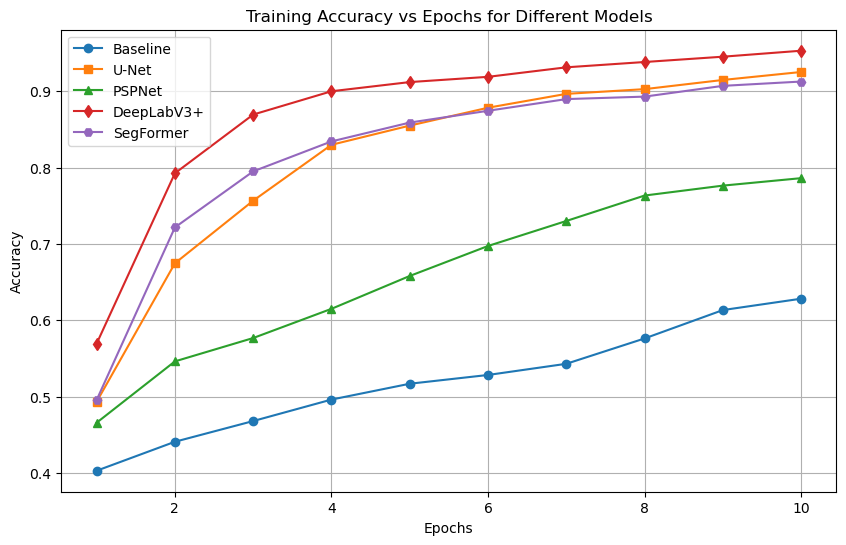

In [3]:
import matplotlib.pyplot as plt

accuracy_per_epoch_baseline = [0.40317604002575785, 0.4410934240356778, 0.468208915855969, 0.49632425334213215, 0.5170578293969261, 0.5285320230011069, 0.5431517723145862, 0.5763487439064628, 0.6134922952677964, 0.6283780547513624]
accuracy_per_epoch_unet = [0.4933918217547258, 0.6747542129225562, 0.7566816033719346, 0.8298413850955807, 0.8549743153418767, 0.8783813809179155, 0.8965177198196952, 0.9027096283208447, 0.9147175053484758, 0.9251550991463726]
accuracy_per_epoch_pspnet = [0.4660022538104564, 0.5463161208649098, 0.5768963140752725, 0.6151251935828934, 0.6581449170853202, 0.6973909383248893, 0.7301165089620232, 0.7634252397500851, 0.7764000333947122, 0.786172061265327]
accuracy_per_epoch_deeplab = [0.5695409956680006, 0.7925800042841025, 0.8694255943194397, 0.8999235480617762, 0.9119508831637432, 0.9188151762336086, 0.9312670964960831, 0.9382196161337705, 0.9451741314713896, 0.9529946142711172]
accuracy_per_epoch_segformer = [0.49572679067502556, 0.7217050495199676, 0.7950437790041723, 0.8342756640358907, 0.8589306241485014, 0.874397381774736, 0.8896698912742678, 0.89290849649289, 0.9070071186616571, 0.9126445551983992]

# Epoch range (10 epochs in your case)
epochs = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model's accuracy
plt.plot(epochs, accuracy_per_epoch_baseline, label='Baseline', marker='o')
plt.plot(epochs, accuracy_per_epoch_unet, label='U-Net', marker='s')
plt.plot(epochs, accuracy_per_epoch_pspnet, label='PSPNet', marker='^')
#plt.plot(epochs, accuracy_per_epoch_fcn, label='FCN', marker='x')
plt.plot(epochs, accuracy_per_epoch_deeplab, label='DeepLabV3+', marker='d')
#plt.plot(epochs, accuracy_per_epoch_deeplab_trans, label='DeepLabV3+ Trans', marker='p')
plt.plot(epochs, accuracy_per_epoch_segformer, label='SegFormer', marker='H')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs for Different Models')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
